In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Torch:", torch.__version__, "| device:", device)

Torch: 2.10.0+cu128 | device: cuda


In [2]:
def synthetic_function_np(X: np.ndarray) -> np.ndarray:
    x1, x2, x3 = X[:, 0], X[:, 1], X[:, 2]
    y = np.sin(x1) + 0.3*(x2**2) - np.exp(-x3) + 0.1*x1*x2*x3
    return y.reshape(-1, 1)

def make_dataset(n=6000, seed=1, noise_std=0.05):
    rng = np.random.default_rng(seed)
    x1 = rng.uniform(-3.0, 3.0, size=(n, 1))
    x2 = rng.uniform(-2.0, 2.0, size=(n, 1))
    x3 = rng.uniform(0.0, 4.0, size=(n, 1))
    X = np.concatenate([x1, x2, x3], axis=1)
    y = synthetic_function_np(X)
    y = y + rng.normal(0.0, noise_std, size=y.shape)
    return X.astype(np.float32), y.astype(np.float32)

def standardize_train_test(X, y, test_frac=0.2, seed=2):
    rng = np.random.default_rng(seed)
    n = X.shape[0]
    idx = rng.permutation(n)
    n_test = int(n * test_frac)
    test_idx, train_idx = idx[:n_test], idx[n_test:]

    Xtr, Xte = X[train_idx], X[test_idx]
    ytr, yte = y[train_idx], y[test_idx]

    X_mean, X_std = Xtr.mean(0, keepdims=True), Xtr.std(0, keepdims=True) + 1e-8
    y_mean, y_std = ytr.mean(0, keepdims=True), ytr.std(0, keepdims=True) + 1e-8

    Xtr = (Xtr - X_mean) / X_std
    Xte = (Xte - X_mean) / X_std
    ytr = (ytr - y_mean) / y_std
    yte = (yte - y_mean) / y_std

    norms = dict(X_mean=X_mean, X_std=X_std, y_mean=y_mean, y_std=y_std)
    return Xtr, ytr, Xte, yte, norms

In [3]:
def plot_loss(losses, title="Training loss"):
    plt.figure()
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title(title)
    plt.show()

def plot_parity(y_true, y_pred, title="Predicted vs Actual"):
    plt.figure()
    plt.scatter(y_true.flatten(), y_pred.flatten(), s=8, alpha=0.6)
    lo = min(y_true.min(), y_pred.min())
    hi = max(y_true.max(), y_pred.max())
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.show()

def plot_4d_pca(X, y, title="4D plot: PCA(X)->3D, color=y"):
    pca = PCA(n_components=3)
    Xp = pca.fit_transform(X)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(Xp[:,0], Xp[:,1], Xp[:,2], c=y.flatten(), s=8, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    fig.colorbar(sc, ax=ax, shrink=0.7, label="y (color)")
    plt.show()


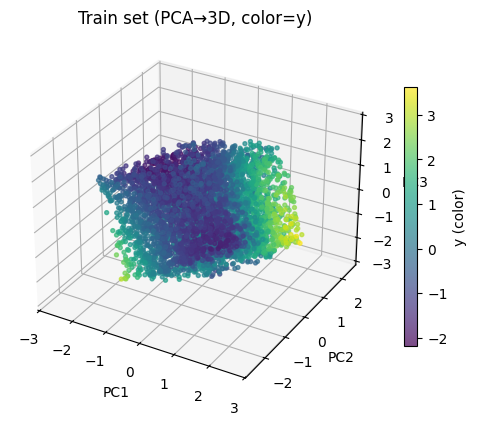

In [4]:
X, y = make_dataset(n=6000, seed=1, noise_std=0.05)
Xtr, ytr, Xte, yte, norms = standardize_train_test(X, y, test_frac=0.2, seed=2)
plot_4d_pca(Xtr, ytr, title="Train set (PCA→3D, color=y)")

Xtr_t = torch.tensor(Xtr, device=device)
ytr_t = torch.tensor(ytr, device=device)
Xte_t = torch.tensor(Xte, device=device)
yte_t = torch.tensor(yte, device=device)


In [5]:
class MLP(nn.Module):
    def __init__(self, d_in=3, h1=64, h2=64, d_out=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, h1),
            nn.Tanh(),
            nn.Linear(h1, h2),
            nn.Tanh(),
            nn.Linear(h2, d_out),
        )

    def forward(self, x):
        return self.net(x)

model = MLP().to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

Epoch  150 | train MSE: 0.010167
Epoch  300 | train MSE: 0.002926
Epoch  450 | train MSE: 0.003015
Epoch  600 | train MSE: 0.002662


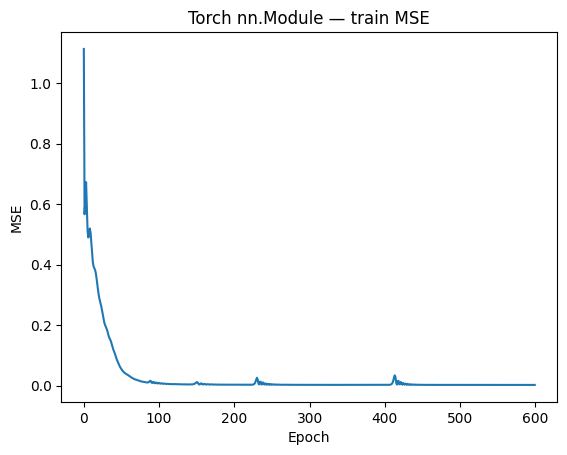

In [6]:
epochs = 600
losses = []

for epoch in range(epochs):
    model.train()
    opt.zero_grad()
    yhat = model(Xtr_t)
    loss = loss_fn(yhat, ytr_t)
    loss.backward()
    opt.step()

    losses.append(loss.item())
    if (epoch + 1) % 150 == 0:
        print(f"Epoch {epoch+1:4d} | train MSE: {loss.item():.6f}")

plot_loss(losses, title="Torch nn.Module — train MSE")

Test MSE (denormalized): 0.0026560784317553043


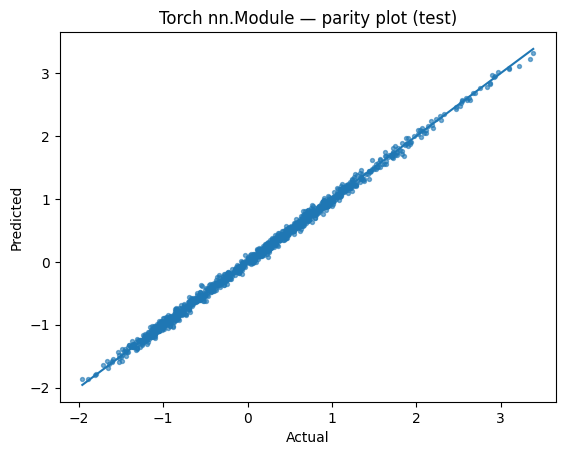

In [7]:
model.eval()
with torch.no_grad():
    yhat_te = model(Xte_t).cpu().numpy()

yhat_te_den = yhat_te * norms["y_std"] + norms["y_mean"]
yte_den = yte * norms["y_std"] + norms["y_mean"]
test_mse = np.mean((yhat_te_den - yte_den)**2)
print("Test MSE (denormalized):", float(test_mse))
plot_parity(yte_den, yhat_te_den, title="Torch nn.Module — parity plot (test)")